In [1]:
# Install required packages
!pip install torch nltk pandas scikit-learn tensorflow sentence-transformers matplotlib seaborn joblib

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split, KFold
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, BatchNormalization, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import pickle

In [3]:
# Download required NLTK data
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
# Load dataset
df = pd.read_csv("/content/hate-speech-and-offensive-language-dataset.csv")

In [5]:
# Enhanced text preprocessing function
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    tokens = text.split()
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

# Apply preprocessing
df['final_tweet'] = df['tweet'].apply(preprocess_text)

In [6]:
# Handle class imbalance by upsampling minority classes
df_majority = df[df['class'] == df['class'].value_counts().idxmax()]
df_minority = df[df['class'] != df['class'].value_counts().idxmax()]
df_minority_upsampled = resample(
    df_minority,
    replace=True,
    n_samples=len(df_majority),
    random_state=42
)
df_balanced = pd.concat([df_majority, df_minority_upsampled])
df_balanced = df_balanced.sample(frac=1, random_state=42)

In [7]:
# Tokenization and sequence padding
max_words = 10000  # Maximum vocabulary size
sentence_length = 100  # Maximum sequence length
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df_balanced['final_tweet'])
X = tokenizer.texts_to_sequences(df_balanced['final_tweet'])
X = pad_sequences(X, maxlen=sentence_length, padding='pre')

In [8]:
# Labels
y = df_balanced['class'].values
num_classes = df['class'].nunique()  # Number of unique classes (3: hate_speech, offensive_language, neither)

In [9]:
# Compute class weights to handle any residual imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weight_dict = dict(enumerate(class_weights))

In [10]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [11]:
# Convert labels to one-hot encoding
y_train = to_categorical(y_train, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

In [12]:
# Define the model
embedding_dim = 100
model = Sequential([
    Embedding(max_words, embedding_dim, input_length=sentence_length),
    Conv1D(128, 5, activation='relu'),
    BatchNormalization(),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(32)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [13]:
# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [14]:
# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    min_lr=1e-6
)

In [15]:
# Build the model to initialize layers
model.build(input_shape=(None, sentence_length))

In [16]:
# Print model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 96, 128)        │        64,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 96, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 96, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 96, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,211,395 (4.62 MB)

 Trainable params: 1,210,947 (4.62 MB)

 Non-trainable params: 448 (1.75 KB)

In [17]:
# Check data types and shapes
print("Data types:")
print("X_train type:", type(X_train))
print("y_train type:", type(y_train))
print("X_test type:", type(X_test))
print("y_test type:", type(y_test))
print("\nChecking for NaN values:")
print("X_train NaN:", np.isnan(X_train).any())
print("y_train NaN:", np.isnan(y_train).any())
print("X_test NaN:", np.isnan(X_test).any())
print("y_test NaN:", np.isnan(y_test).any())
print("\nData ranges:")
print("X_train range:", np.min(X_train), "to", np.max(X_train))
print("y_train range:", np.min(y_train), "to", np.max(y_train))

Data types:
X_train type: <class 'numpy.ndarray'>
y_train type: <class 'numpy.ndarray'>
X_test type: <class 'numpy.ndarray'>
y_test type: <class 'numpy.ndarray'>

Checking for NaN values:
X_train NaN: False
y_train NaN: False
X_test NaN: False
y_test NaN: False

Data ranges:
X_train range: 0 to 9999
y_train range: 0.0 to 1.0


In [ ]:
# K-fold CROSS-VALIDATION
n_splits = 5
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
fold_accuracies = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(X, y)):
    print(f'Training Fold {fold + 1}/{n_splits}')

    # Get fold data
    X_train_fold, X_val_fold = X[train_idx], X[val_idx]
    y_train_fold, y_val_fold = y[train_idx], y[val_idx]

    # Convert labels to one-hot encoding
    y_train_fold = to_categorical(y_train_fold, num_classes=num_classes)
    y_val_fold = to_categorical(y_val_fold, num_classes=num_classes)

    # Reset model weights
    model = Sequential([
        Embedding(max_words, embedding_dim, input_length=sentence_length),
        Conv1D(128, 5, activation='relu'),
        BatchNormalization(),
        Bidirectional(LSTM(64, return_sequences=True)),
        Dropout(0.3),
        Bidirectional(LSTM(32)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Train the model
    history = model.fit(
        X_train_fold,
        y_train_fold,
        validation_data=(X_val_fold, y_val_fold),
        # epochs=20,
        epochs=5,
        batch_size=32,
        callbacks=[early_stopping, reduce_lr],
        class_weight=class_weight_dict,
        verbose=1
    )

    # Evaluate on validation fold
    val_loss, val_accuracy = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    fold_accuracies.append(val_accuracy)
    print(f'Fold {fold + 1} Validation Accuracy: {val_accuracy * 100:.2f}%')

print(f'Average Validation Accuracy: {np.mean(fold_accuracies) * 100:.2f}%')

In [20]:
# Train final model on full training data
model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weight_dict,
    verbose=1
)

Epoch 1/10
960/960 ━━━━━━━━━━━━━━━━━━━━ 155s 162ms/step - accuracy: 0.9460 - loss: 0.1899 - val_accuracy: 0.9500 - val_loss: 0.1799 - learning_rate: 0.0010
Epoch 2/10
960/960 ━━━━━━━━━━━━━━━━━━━━ 205s 165ms/step - accuracy: 0.9673 - loss: 0.1215 - val_accuracy: 0.9484 - val_loss: 0.1753 - learning_rate: 0.0010
Epoch 3/10
960/960 ━━━━━━━━━━━━━━━━━━━━ 196s 159ms/step - accuracy: 0.9761 - loss: 0.0867 - val_accuracy: 0.9459 - val_loss: 0.2118 - learning_rate: 0.0010
Epoch 4/10
960/960 ━━━━━━━━━━━━━━━━━━━━ 202s 160ms/step - accuracy: 0.9833 - loss: 0.0606 - val_accuracy: 0.9480 - val_loss: 0.2219 - learning_rate: 0.0010
Epoch 5/10
960/960 ━━━━━━━━━━━━━━━━━━━━ 201s 159ms/step - accuracy: 0.9889 - loss: 0.0476 - val_accuracy: 0.9717 - val_loss: 0.1375 - learning_rate: 2.0000e-04
Epoch 6/10
960/960 ━━━━━━━━━━━━━━━━━━━━ 202s 159ms/step - accuracy: 0.9950 - loss: 0.0228 - val_accuracy: 0.9677 - val_loss: 0.1694 - learning_rate: 2.0000e-04
Epoch 7/10
960/960 ━━━━━━━━━━━━━━━━━━━━ 199s 156ms/step 

In [21]:
# Evaluate on test set
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

Test Accuracy: 97.17%


In [22]:
# Detailed evaluation
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

print("\nClassification Report:")
print(classification_report(
    y_true_classes,
    y_pred_classes,
    target_names=['hate_speech', 'offensive_language', 'neither']
))

240/240 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step

Classification Report:
                    precision    recall  f1-score   support

       hate_speech       0.90      0.97      0.94       991
offensive_language       0.99      0.96      0.97      3838
           neither       0.98      0.99      0.98      2847

          accuracy                           0.97      7676
         macro avg       0.96      0.97      0.96      7676
      weighted avg       0.97      0.97      0.97      7676



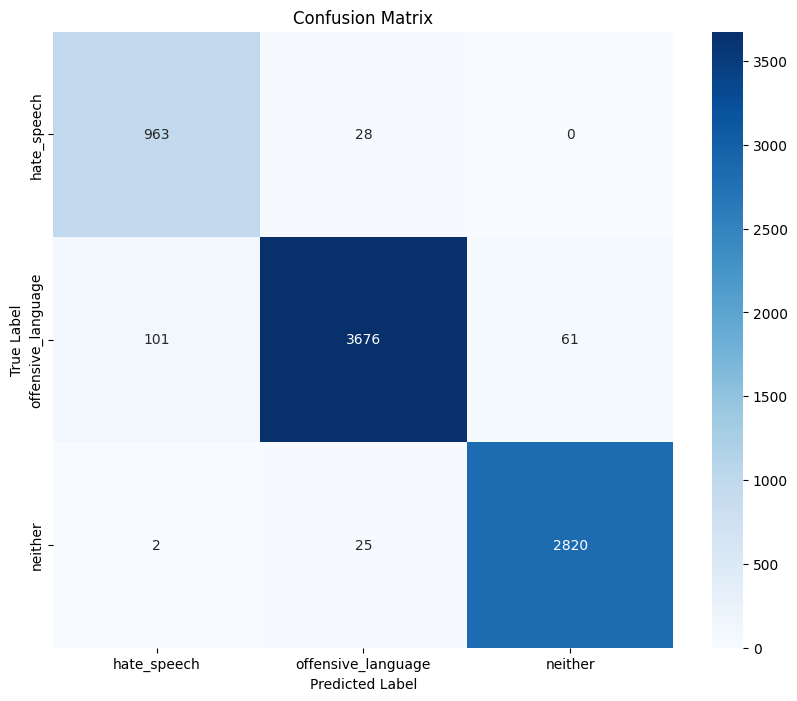

In [23]:
# Plot confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true_classes, y_pred_classes)
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['hate_speech', 'offensive_language', 'neither'],
    yticklabels=['hate_speech', 'offensive_language', 'neither']
)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [24]:
# Save the model and tokenizer
model.save('model_hate_speech.h5')
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

In [25]:
# Prediction function
def predict_hate_speech(text):
    # Preprocess text
    processed_text = preprocess_text(text)
    sequence = tokenizer.texts_to_sequences([processed_text])
    padded = pad_sequences(sequence, padding='pre', maxlen=sentence_length)

    # Predict
    prediction = model.predict(padded)
    probabilities = prediction[0]
    predicted_class = np.argmax(probabilities)
    probability = probabilities[predicted_class]

    # Class labels
    class_labels = ['hate_speech', 'offensive_language', 'neither']

    # Print probabilities
    print("\nClass probabilities:")
    for label, prob in zip(class_labels, probabilities):
        print(f"{label}: {prob:.2%}")

    predicted_label = class_labels[predicted_class]
    return predicted_label, float(probability)

# Test predictions
test_texts = [
    "I love this product!",
    "You are so stupid",
    "This is amazing",
    "I hate you",
    "This is a normal day"
]

for text in test_texts:
    print(f"\n{'='*50}")
    print(f"Text: {text}")
    label, prob = predict_hate_speech(text)
    print(f"Final prediction: {label}")
    print(f"Confidence: {prob:.2%}")


Text: I love this product!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step

Class probabilities:
hate_speech: 0.08%
offensive_language: 0.10%
neither: 99.81%
Final prediction: neither
Confidence: 99.81%

Text: You are so stupid
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step

Class probabilities:
hate_speech: 9.61%
offensive_language: 89.86%
neither: 0.53%
Final prediction: offensive_language
Confidence: 89.86%

Text: This is amazing
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step

Class probabilities:
hate_speech: 0.15%
offensive_language: 0.16%
neither: 99.69%
Final prediction: neither
Confidence: 99.69%

Text: I hate you
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step

Class probabilities:
hate_speech: 99.56%
offensive_language: 0.44%
neither: 0.01%
Final prediction: hate_speech
Confidence: 99.56%

Text: This is a normal day
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step

Class probabilities:
hate_speech: 3.20%
offensive_language: 6.91%
neither: 89.89%
Final prediction: neither
Confidence: 89.89%
